In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torch.nn.functional import one_hot

from data_loaders.pulja_data_loader import PuljaDataLoader
from models._20220629_00 import UserModel
from models.utils import collate_fn

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    from torch import FloatTensor, LongTensor

In [2]:
ckpt_path = "ckpts"
if not os.path.isdir(ckpt_path):
    os.mkdir(ckpt_path)

batch_size = 256
num_epochs = 100
train_ratio = 0.9

seq_len = 100

dim_v = 20

dataset = PuljaDataLoader(seq_len)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = UserModel(dataset.num_c1, dataset.num_c2, dataset.num_d, dim_v).to(device)

train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size]
)

if os.path.exists(os.path.join(dataset.dataset_dir, "indices.pkl")):
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "rb") as f:
        indices = pickle.load(f)
    train_dataset.indices = indices[0]
    test_dataset.indices = indices[1]
else:
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "wb") as f:
        pickle.dump((train_dataset.indices, test_dataset.indices), f)


In [3]:
tb_unit1 = pd.read_csv(
    os.path.join("tables", "tb_unit1.csv")
)
tb_unit2 = pd.read_csv(
    os.path.join("tables", "tb_unit2.csv")
)

c22c1 = {}
for _, row in tb_unit2.iterrows():
    c2 = row["name"]
    c1 = tb_unit1[tb_unit1["unit1Seq"] == row["unit1Seq"]]["name"].values[0]
    
    c22c1[c2] = c1

c22c1_indices = [dataset.c12idx[c22c1[c2]] for c2 in [dataset.c2_list[i] for i in range(dataset.num_c2)]]

In [4]:
model.load_state_dict(
    torch.load(
        os.path.join(
            os.path.join(
                ckpt_path, "_20220629_00"
            ),
            "model_fin.ckpt"
        ),
        map_location=device
    )
)
model.eval()

UserModel(
  (D): Embedding(7, 1)
  (R): Embedding(2, 20)
  (gru): GRU(40, 20, batch_first=True)
  (linear_1): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=1, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=80, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=2, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
)

In [5]:
start_seq = 0
# end_seq = 112917
end_seq = 107788

In [6]:
df_u = dataset.df[dataset.df["userSeq"] == 457]
df_u = df_u[(df_u["seq"] >= start_seq) & (df_u["seq"] <= end_seq)]

In [7]:
df_u

,seq,cunitSeq,userSeq,question_id,answer,isCorrect,duration,regdate,difficulty_cd,category1,category2,category3,category4,category5
9914,9966,42889,457,3378,④,Y,126,2021-07-21 16:51:46,1.0,1 집합과 명제,01 집합의 뜻과 표현,01 집합의 뜻과 표현,[1] 집합의 뜻,[유형 01 1] 집합의 뜻
9916,9968,42889,457,4009,③,Y,87,2021-07-21 16:53:14,1.0,1 집합과 명제,01 집합의 뜻과 표현,01 집합의 뜻과 표현,[1] 집합의 뜻,[유형 01 1] 집합의 뜻
9917,9969,42889,457,3383,⑤③,Y,47,2021-07-21 16:54:02,2.0,1 집합과 명제,01 집합의 뜻과 표현,01 집합의 뜻과 표현,[1] 집합의 뜻,[유형 01 1] 집합의 뜻
9918,9970,42889,457,3385,⑤④,Y,60,2021-07-21 16:55:02,2.0,1 집합과 명제,01 집합의 뜻과 표현,01 집합의 뜻과 표현,[1] 집합의 뜻,[유형 01 1] 집합의 뜻
9919,9971,42889,457,4027,③,Y,63,2021-07-21 16:56:06,2.0,1 집합과 명제,01 집합의 뜻과 표현,01 집합의 뜻과 표현,[1] 집합의 뜻,[유형 01 1] 집합의 뜻
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107693,107784,176225,457,4819,432,Y,33,2021-12-13 21:41:41,4.0,3 경우의 수,07 경우의 수와 순열,02 순열,[9] 이웃하는 순열의 수,[유형 12 3] 이웃하는 순열의 수-2가지 이상의 경우로 나뉠 때
107694,107785,176225,457,4806,30,Y,40,2021-12-13 21:42:23,4.0,3 경우의 수,07 경우의 수와 순열,02 순열,[13] 순열을 이용한 자연수의 개수,[유형 16 2] 자연수의 개수-배수의 개수
107695,107786,176225,457,5649,36,Y,27,2021-12-13 21:42:51,4.0,3 경우의 수,08 조합,01 조합,[7] 직선의 개수,[유형 07 2] 직선의 개수-조건을 만족시키지 않는 것을 제외하는 경우
107696,107787,176225,457,5650,200,Y,29,2021-12-13 21:43:21,4.0,3 경우의 수,08 조합,01 조합,[9] 삼각형의 개수,[유형 09 1] 다각형의 개수(1)-삼각형


In [8]:
df_u.iloc[-50:]

,seq,cunitSeq,userSeq,question_id,answer,isCorrect,duration,regdate,difficulty_cd,category1,category2,category3,category4,category5
105352,105443,171407,457,4923,266,N,196,2021-12-09 18:50:55,5.0,3 경우의 수,08 조합,01 조합,[9] 삼각형의 개수,[유형 09 1] 다각형의 개수(1)-삼각형
105353,105444,171407,457,4911,160,Y,37,2021-12-09 18:51:33,4.0,3 경우의 수,08 조합,01 조합,[9] 삼각형의 개수,[유형 09 2] 다각형의 개수(1)-특정한 삼각형을 제외하는 경우
105354,105445,171408,457,5647,82,Y,50,2021-12-09 18:52:39,3.0,3 경우의 수,08 조합,01 조합,[10] 사각형의 개수,[유형 10 1] 다각형의 개수(2)-사각형
105355,105446,171408,457,5214,③,Y,124,2021-12-09 18:54:44,3.0,3 경우의 수,08 조합,01 조합,[10] 사각형의 개수,[유형 10 2] 다각형의 개수(2)-특정한 사각형을 제외하는 경우
105356,105447,171408,457,4007,⑥,N,131,2021-12-09 18:56:56,5.0,3 경우의 수,08 조합,01 조합,[10] 사각형의 개수,[유형 10 2] 다각형의 개수(2)-특정한 사각형을 제외하는 경우
105357,105448,171409,457,5213,90,Y,14,2021-12-09 18:57:15,3.0,3 경우의 수,08 조합,01 조합,[10] 사각형의 개수,[유형 11 1] 평행사변형의 개수
105358,105449,171409,457,4889,6,Y,74,2021-12-09 18:58:30,4.0,3 경우의 수,08 조합,01 조합,[10] 사각형의 개수,[유형 11 2] 평행사변형의 개수-평행사변형의 개수가 주어진 경우
105360,105451,171412,457,5212,②,Y,7,2021-12-09 19:22:10,3.0,3 경우의 수,08 조합,01 조합,[13] 함수의 개수,[유형 14 1] 함수의 개수
105361,105452,171412,457,4915,15,N,57,2021-12-09 19:23:07,4.0,3 경우의 수,08 조합,01 조합,[13] 함수의 개수,[유형 14 1] 함수의 개수
105362,105453,171412,457,5645,①,Y,40,2021-12-09 19:23:49,4.0,3 경우의 수,08 조합,01 조합,[13] 함수의 개수,[유형 14 1] 함수의 개수


In [9]:
df_temp = df_u[(df_u["seq"] >= start_seq) & (df_u["seq"] <= 10034)]

c1_seq_temp = np.array(
    [dataset.c12idx[c1] for c1 in df_temp["category1"].values]
)
c2_seq_temp = np.array(
    [dataset.c22idx[c2] for c2 in df_temp["category2"].values]
)
d_seq_temp = np.array(
    [dataset.d2idx[d] for d in df_temp["difficulty_cd"].values]
)

T_seq_temp = df_temp["duration"].values
T_hat_seq_temp = np.array(
    [dataset.difficulty2duration[dataset.d_list[d]] for d in d_seq_temp]
)
TR_seq_temp = T_seq_temp / T_hat_seq_temp

r_seq_temp = (df_temp["isCorrect"].values == "Y").astype(float)
r_seq_temp = dataset.get_response(r_seq_temp, TR_seq_temp)

In [10]:
np.mean(df_u[(df_u["seq"] >= start_seq) & (df_u["seq"] <= 10034)]["isCorrect"].values == "Y")

0.9183673469387755

In [11]:
np.mean(r_seq_temp)

0.8367346938775511

In [12]:
df_temp = df_u[(df_u["seq"] >= 107340) & (df_u["seq"] <= end_seq)]

c1_seq_temp = np.array(
    [dataset.c12idx[c1] for c1 in df_temp["category1"].values]
)
c2_seq_temp = np.array(
    [dataset.c22idx[c2] for c2 in df_temp["category2"].values]
)
d_seq_temp = np.array(
    [dataset.d2idx[d] for d in df_temp["difficulty_cd"].values]
)

T_seq_temp = df_temp["duration"].values
T_hat_seq_temp = np.array(
    [dataset.difficulty2duration[dataset.d_list[d]] for d in d_seq_temp]
)
TR_seq_temp = T_seq_temp / T_hat_seq_temp

r_seq_temp = (df_temp["isCorrect"].values == "Y").astype(float)
r_seq_temp = dataset.get_response(r_seq_temp, TR_seq_temp)

In [13]:
np.mean(df_u[(df_u["seq"] >= 107340) & (df_u["seq"] <= end_seq)]["isCorrect"].values == "Y")

0.9310344827586207

In [14]:
np.mean(r_seq_temp)

0.9310344827586207

In [15]:
c1_seq = np.array(
    [dataset.c12idx[c1] for c1 in df_u["category1"].values]
)
c2_seq = np.array(
    [dataset.c22idx[c2] for c2 in df_u["category2"].values]
)
d_seq = np.array(
    [dataset.d2idx[d] for d in df_u["difficulty_cd"].values]
)

T_seq = df_u["duration"].values
T_hat_seq = np.array(
    [dataset.difficulty2duration[dataset.d_list[d]] for d in d_seq]
)
TR_seq = T_seq / T_hat_seq

r_seq = (df_u["isCorrect"].values == "Y").astype(float)
r_seq = dataset.get_response(r_seq, TR_seq)

In [16]:
c1_seq, c2_seq, d_seq, r_seq

(array([3, 3, 3, ..., 5, 5, 5]),
 array([166, 166, 166, ..., 180, 180, 180]),
 array([0, 0, 1, ..., 3, 3, 3]),
 array([0., 1., 1., ..., 1., 1., 1.]))

In [17]:
alpha_seq, h_seq, C1_seq, C2_seq = model(
    LongTensor([c1_seq]),
    LongTensor([c2_seq]),
    LongTensor([d_seq]),
    LongTensor([r_seq]),
)

<ipython-input-17-c2c9f8a4e82e>:5: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  LongTensor([r_seq]),


In [18]:
alpha_seq.shape

torch.Size([1, 4032])

In [19]:
alpha_seq, h_seq, C1_seq, C2_seq = model(
    LongTensor([c1_seq]),
    LongTensor([c2_seq]),
    LongTensor([d_seq]),
    LongTensor([r_seq]),
)
# alpha_seq = alpha_seq.squeeze()

sigmoid_alpha_seq = torch.sigmoid(alpha_seq).detach().cpu().numpy()[0]

CQ_seq = alpha_seq.unsqueeze(-1) + C1_seq.squeeze()[:, c22c1_indices] + C2_seq.squeeze()
CQ_seq = torch.sigmoid(CQ_seq).detach().cpu().numpy()[0]

C1_seq = C1_seq.squeeze().detach().cpu().numpy()
C2_seq = C2_seq.squeeze().detach().cpu().numpy()

<ipython-input-19-ac38b8324f0e>:5: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  LongTensor([r_seq]),


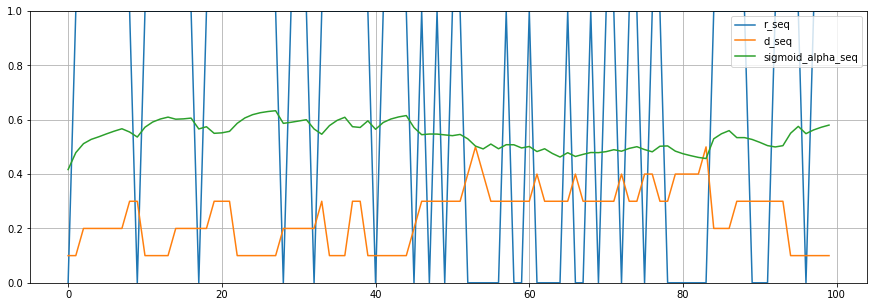

In [20]:
plt.figure(figsize=[15, 5], facecolor="white")
plt.plot(r_seq[:100], label="r_seq")
plt.plot((d_seq[:100] + 1) / 10, label="d_seq")
plt.plot(sigmoid_alpha_seq[:100], label="sigmoid_alpha_seq")
plt.grid()
plt.ylim(0, 1)
plt.legend()
plt.show()

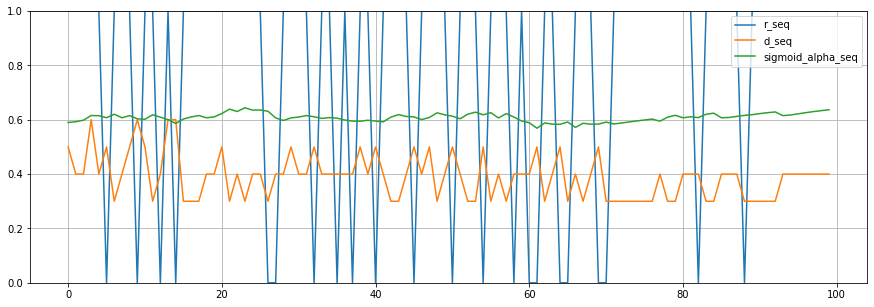

In [21]:
plt.figure(figsize=[15, 5], facecolor="white")
plt.plot(r_seq[-100:], label="r_seq")
plt.plot((d_seq[-100:] + 1) / 10, label="d_seq")
plt.plot(sigmoid_alpha_seq[-100:], label="sigmoid_alpha_seq")
plt.grid()
plt.ylim(0, 1)
plt.legend()
plt.show()

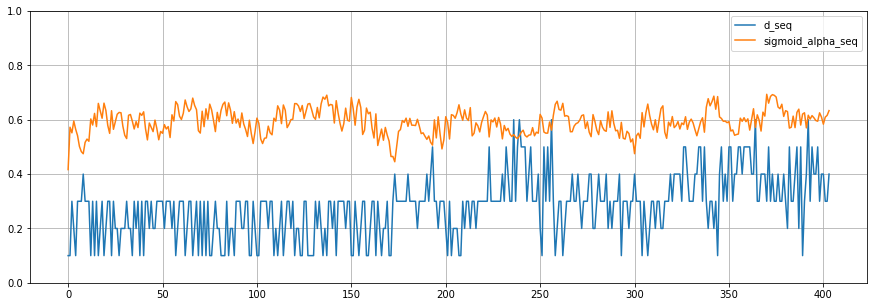

In [22]:
plt.figure(figsize=[15, 5], facecolor="white")
# plt.plot(r_seq[::10], label="r_seq")
plt.plot((d_seq[::10] + 1) / 10, label="d_seq")
plt.plot(sigmoid_alpha_seq[::10], label="sigmoid_alpha_seq")
plt.grid()
plt.ylim(0, 1)
plt.legend()
plt.show()

In [23]:
CQ_seq.shape, r_seq.shape

((4032, 181), (4032,))

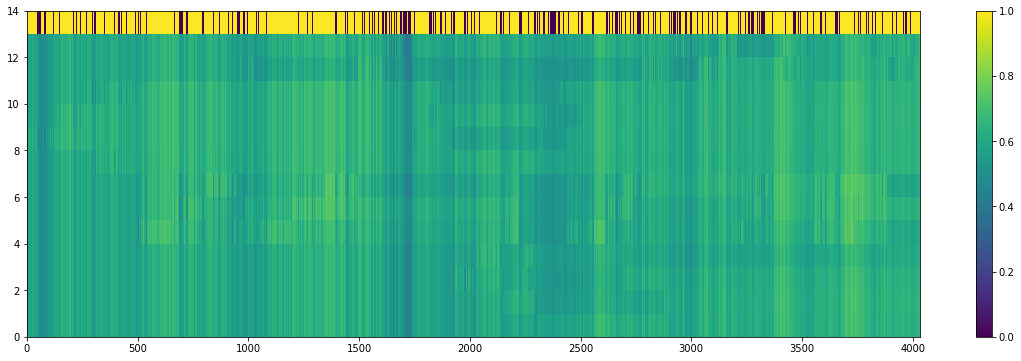

In [24]:
plt.figure(figsize=[20, len(np.unique(c2_seq)) // 2], facecolor="white")
temp = np.concatenate([CQ_seq[:, np.unique(c2_seq)].T, [r_seq]], axis=0)
plt.pcolormesh(temp)
plt.colorbar()
plt.show()

# plt.figure(figsize=[15, 0.5], facecolor="white")
# plt.pcolormesh(r_seq)
# plt.show()

In [25]:
true_indices = \
    (dataset.c2_list == "01 집합의 뜻과 표현") | \
    (dataset.c2_list == "02 집합의 연산") | \
    (dataset.c2_list == "03 명제") | \
    (dataset.c2_list == "04 함수") | \
    (dataset.c2_list == "05 유리함수") | \
    (dataset.c2_list == "06 무리함수") | \
    (dataset.c2_list == "07 경우의 수와 순열") | \
    (dataset.c2_list == "08 조합")

In [26]:
true_indices

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [27]:
CQ_seq[0][true_indices], CQ_seq[48][true_indices], CQ_seq[-1][true_indices], c1_seq, c2_seq, d_seq

(array([0.41661692, 0.41661692, 0.41661692, 0.41661692, 0.41661692,
        0.41661692, 0.41661692, 0.41661692, 0.41661692, 0.41661692,
        0.41661692, 0.37568617, 0.41661692, 0.41661692, 0.41661692,
        0.41661692], dtype=float32),
 array([0.5471432, 0.5471432, 0.5471432, 0.5471432, 0.5471432, 0.5471432,
        0.5471432, 0.5471432, 0.5471432, 0.5471432, 0.5471432, 0.563742 ,
        0.5471432, 0.5471432, 0.5471432, 0.5471432], dtype=float32),
 array([0.63667935, 0.63667935, 0.63667935, 0.626618  , 0.626618  ,
        0.626618  , 0.63667935, 0.63667935, 0.6267656 , 0.6651936 ,
        0.61703974, 0.6720887 , 0.6735939 , 0.67140836, 0.67503166,
        0.674963  ], dtype=float32),
 array([3, 3, 3, ..., 5, 5, 5]),
 array([166, 166, 166, ..., 180, 180, 180]),
 array([0, 0, 1, ..., 3, 3, 3]))

In [28]:
dataset.c2_list[true_indices]

array(['01 집합의 뜻과 표현', '02 집합의 연산', '03 명제', '04 함수', '05 유리함수',
       '06 무리함수', '07 경우의 수와 순열', '08 조합', '04 함수', '05 유리함수', '06 무리함수',
       '01 집합의 뜻과 표현', '02 집합의 연산', '03 명제', '07 경우의 수와 순열', '08 조합'],
      dtype=object)

In [29]:
sigmoid_alpha_seq[0], sigmoid_alpha_seq[48], sigmoid_alpha_seq[-1], c1_seq, c2_seq, d_seq

(0.41661692,
 0.5471432,
 0.63667935,
 array([3, 3, 3, ..., 5, 5, 5]),
 array([166, 166, 166, ..., 180, 180, 180]),
 array([0, 0, 1, ..., 3, 3, 3]))

In [30]:
model.D.weight

Parameter containing:
tensor([[-0.7914],
        [-0.5610],
        [-0.2355],
        [ 0.2419],
        [ 0.5852],
        [ 0.7587],
        [ 0.9620]], requires_grad=True)

In [32]:
x = torch.zeros([1, 2, 3])

In [33]:
x.shape

torch.Size([1, 2, 3])

In [39]:
x.repeat(1, 3, 2).shape

torch.Size([1, 6, 6])